In [4]:
import os
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [5]:
def histogram(array, nbins=100):
    """
    Draw histogram from distribution and identify centers.
    Parameters
    ---------
    array: `class::np.array`
            Scores distribution
    nbins: int
            Number of bins to use in the histogram
    Return
    ---------
    float
            Histogram values and bin centers.
    """
    array = array.ravel().flatten()
    hist, bin_edges = np.histogram(array, bins=nbins, range=None)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    return hist, bin_centers


def threshold_otsu(array, nbins=100):
    """
    Apply Otsu threshold on topic-region distributions [Otsu, 1979].
    Parameters
    ---------
    array: `class::np.array`
            Array containing the region values for the topic to be binarized.
    nbins: int
            Number of bins to use in the binarization histogram
    Return
    ---------
    float
            Binarization threshold.
    Reference
    ---------
    Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and
    cybernetics, 9(1), pp.62-66.
    """
    hist, bin_centers = histogram(array, nbins)
    hist = hist.astype(float)
    # Class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # Class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    return threshold

Calculate the threshols and write a tsv file with barcodes to merge:

BIO_ddseq_m1c1.FULL
	threshold: 0.019277819077563776
	npairs_merged: 12036


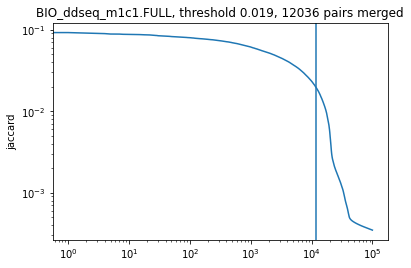

BIO_ddseq_m1c2.FULL
	threshold: 0.022881031878306105
	npairs_merged: 14202


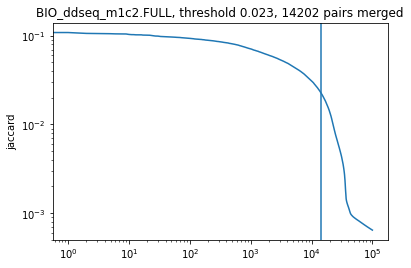

BIO_ddseq_m1c3.FULL
	threshold: 0.023828875931117606
	npairs_merged: 11367


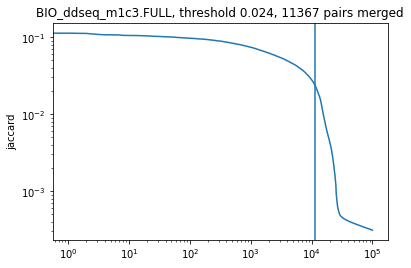

BIO_ddseq_m1c4.FULL
	threshold: 0.023759511586342395
	npairs_merged: 11531


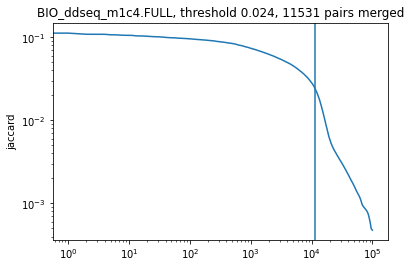

BIO_ddseq_m1c5.FULL
	threshold: 0.032574829984924975
	npairs_merged: 12892


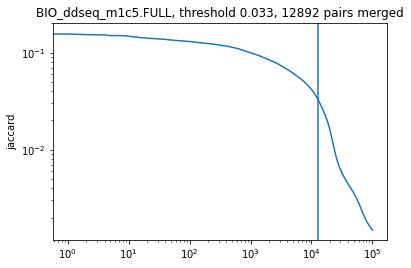

BIO_ddseq_m1c6.FULL
	threshold: 0.02190939051254003
	npairs_merged: 11679


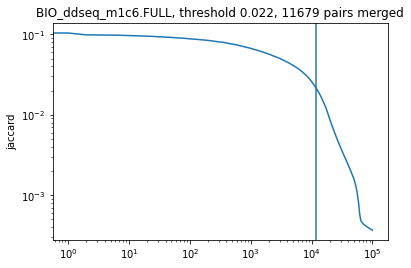

BIO_ddseq_m1c7.FULL
	threshold: 0.02136355016861185
	npairs_merged: 9220


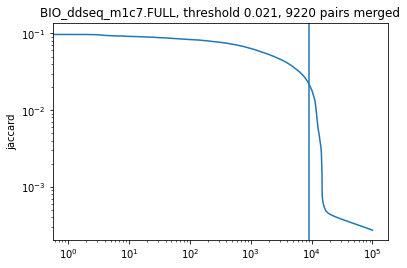

BIO_ddseq_m1c8.FULL
	threshold: 0.02906843593696951
	npairs_merged: 6795


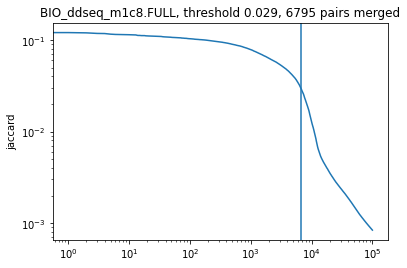

BIO_ddseq_m2c1.FULL
	threshold: 0.1069668375458807
	npairs_merged: 6967


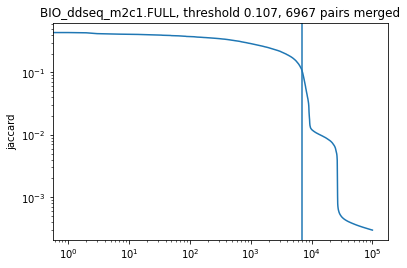

BIO_ddseq_m2c2.FULL
	threshold: 0.0887913773365083
	npairs_merged: 5858


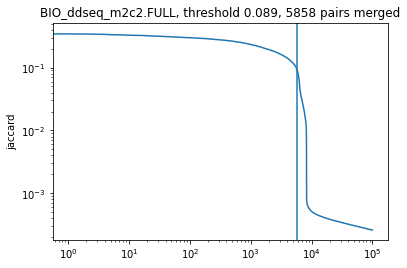

BIO_ddseq_m2c3.FULL
	threshold: 0.08865276592073758
	npairs_merged: 5407


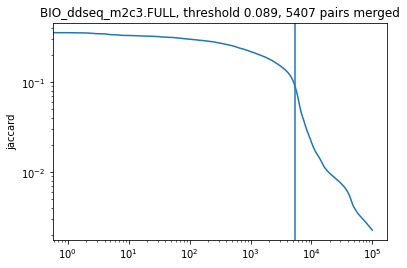

BIO_ddseq_m2c4.FULL
	threshold: 0.09305637980849502
	npairs_merged: 4799


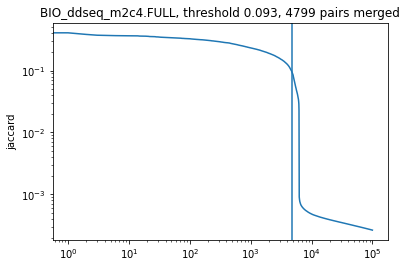

OHS_s3atac_s3ATAC_Mouse.FULL
plts_scratch/OHS_s3atac_s3ATAC_Mouse.FULL.barcard_jaccard_kneeplot.png exists, printing img and skipping
TXG_10xmultiome_e18mousebrainfresh.FULL
plts_scratch/TXG_10xmultiome_e18mousebrainfresh.FULL.barcard_jaccard_kneeplot.png exists, printing img and skipping
TXG_10xv11_adultmousecortexchromiumx.FULL
plts_scratch/TXG_10xv11_adultmousecortexchromiumx.FULL.barcard_jaccard_kneeplot.png exists, printing img and skipping
TXG_10xv1_adultmousefresh.FULL
plts_scratch/TXG_10xv1_adultmousefresh.FULL.barcard_jaccard_kneeplot.png exists, printing img and skipping
TXG_10xv2_adultmousecortex.FULL
plts_scratch/TXG_10xv2_adultmousecortex.FULL.barcard_jaccard_kneeplot.png exists, printing img and skipping
TXG_10xv2_adultmousecortexchromiumx.FULL
plts_scratch/TXG_10xv2_adultmousecortexchromiumx.FULL.barcard_jaccard_kneeplot.png exists, printing img and skipping
VIB_hydrop_1.FULL
	threshold: 0.03
	npairs_merged: 17847


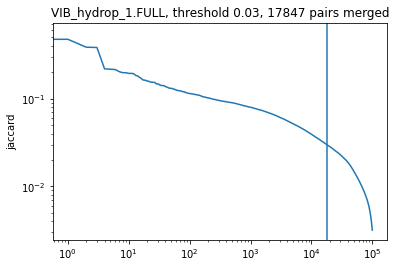

VIB_hydrop_2.FULL
	threshold: 0.03
	npairs_merged: 9014


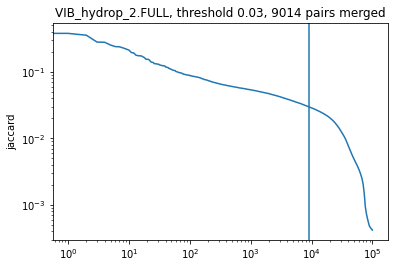

VIB_hydrop_3.FULL
	threshold: 0.03
	npairs_merged: 14883


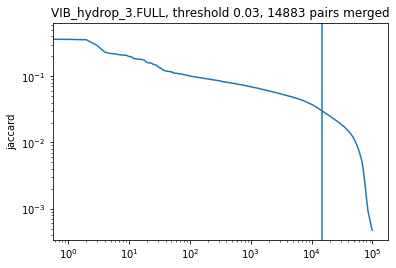

VIB_hydrop_4.FULL
	threshold: 0.03
	npairs_merged: 5508


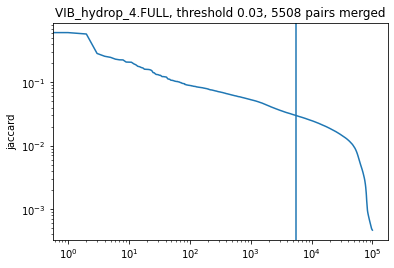

VIB_hydrop_5.FULL
	threshold: 0.032401730803602286
	npairs_merged: 22738


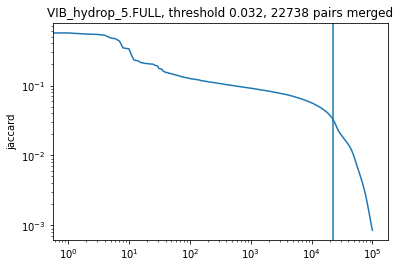

In [6]:
threshold_dict = {}
threshold_rank_dict = {}
for file in sorted(
    glob.glob("public_preprocessing_output/data/reports/barcard/*barcard.overlap.tsv")
):
    sample = file.split("/")[-1].split(".barcard.overlap.tsv")[0]
    print(sample)
    plot_path = f"plts_scratch/{sample}.barcard_jaccard_kneeplot.png"

    if "ddseq" in sample:
        threshold_min = 0.0003
    else:
        threshold_min = 0.03

    if not os.path.exists(plot_path):
        df = pd.read_csv(file, header=0, sep="\t")

        df = df.sort_values(by="jaccard", ascending=False)[:100000]
        df.reset_index(inplace=True, drop=True)

        threshold = threshold_otsu(df["jaccard"])
        if threshold < threshold_min:
            threshold = threshold_min
        threshold_dict[sample] = threshold
        threshold_rank = sum(df["jaccard"] > threshold)
        threshold_rank_dict[sample] = threshold_rank
        print(f"\tthreshold: {threshold}")
        print(f"\tnpairs_merged: {threshold_rank}")

        f, ax = plt.subplots(1, 1)
        sns.lineplot(data=df, x=range(len(df)), y="jaccard", ax=ax)
        # ax.axhline(y=threshold, xmin=0, xmax=10000000)
        ax.axvline(x=threshold_rank, ymin=0.0001, ymax=1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(sample)
        ax.set_title(
            f"{sample}, threshold {round(threshold, 3)}, {threshold_rank} pairs merged"
        )
        plt.savefig(
            plot_path,
            dpi=300,
            facecolor="white",
        )
        df.iloc[:threshold_rank].to_csv(
            f"public_preprocessing_output/data/reports/barcard/{sample}.tomerge.tsv",
            sep="\t",
            index=False,
        )
        plt.show()
        plt.close()

    else:
        print(f"{plot_path} exists, printing img and skipping")

Do not use the merged barcodes for hydrop and 10x, too noisy.